# FPFL Demo

Colab Link: https://colab.research.google.com/drive/1SJBMF8yjOKP7MZcREszvd2mD73U3HdyJ?usp=sharing

This notebook provides a demo implememntation of FPFL (https://arxiv.org/pdf/2108.09932.pdf) as part of our tutorial "Fair and Private Deep Learning" at CODS-COMAD 2024. For the material covered in the tutorial, please visit our repo: https://github.com/magnetar-iiith/FairPrivateDL

## FPFL: Protocol

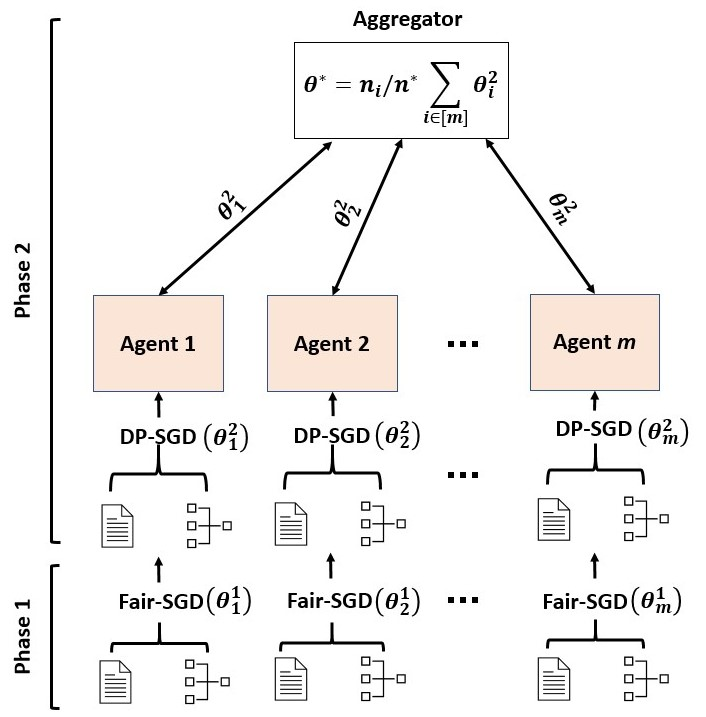

## Results

### ADULT Dataset

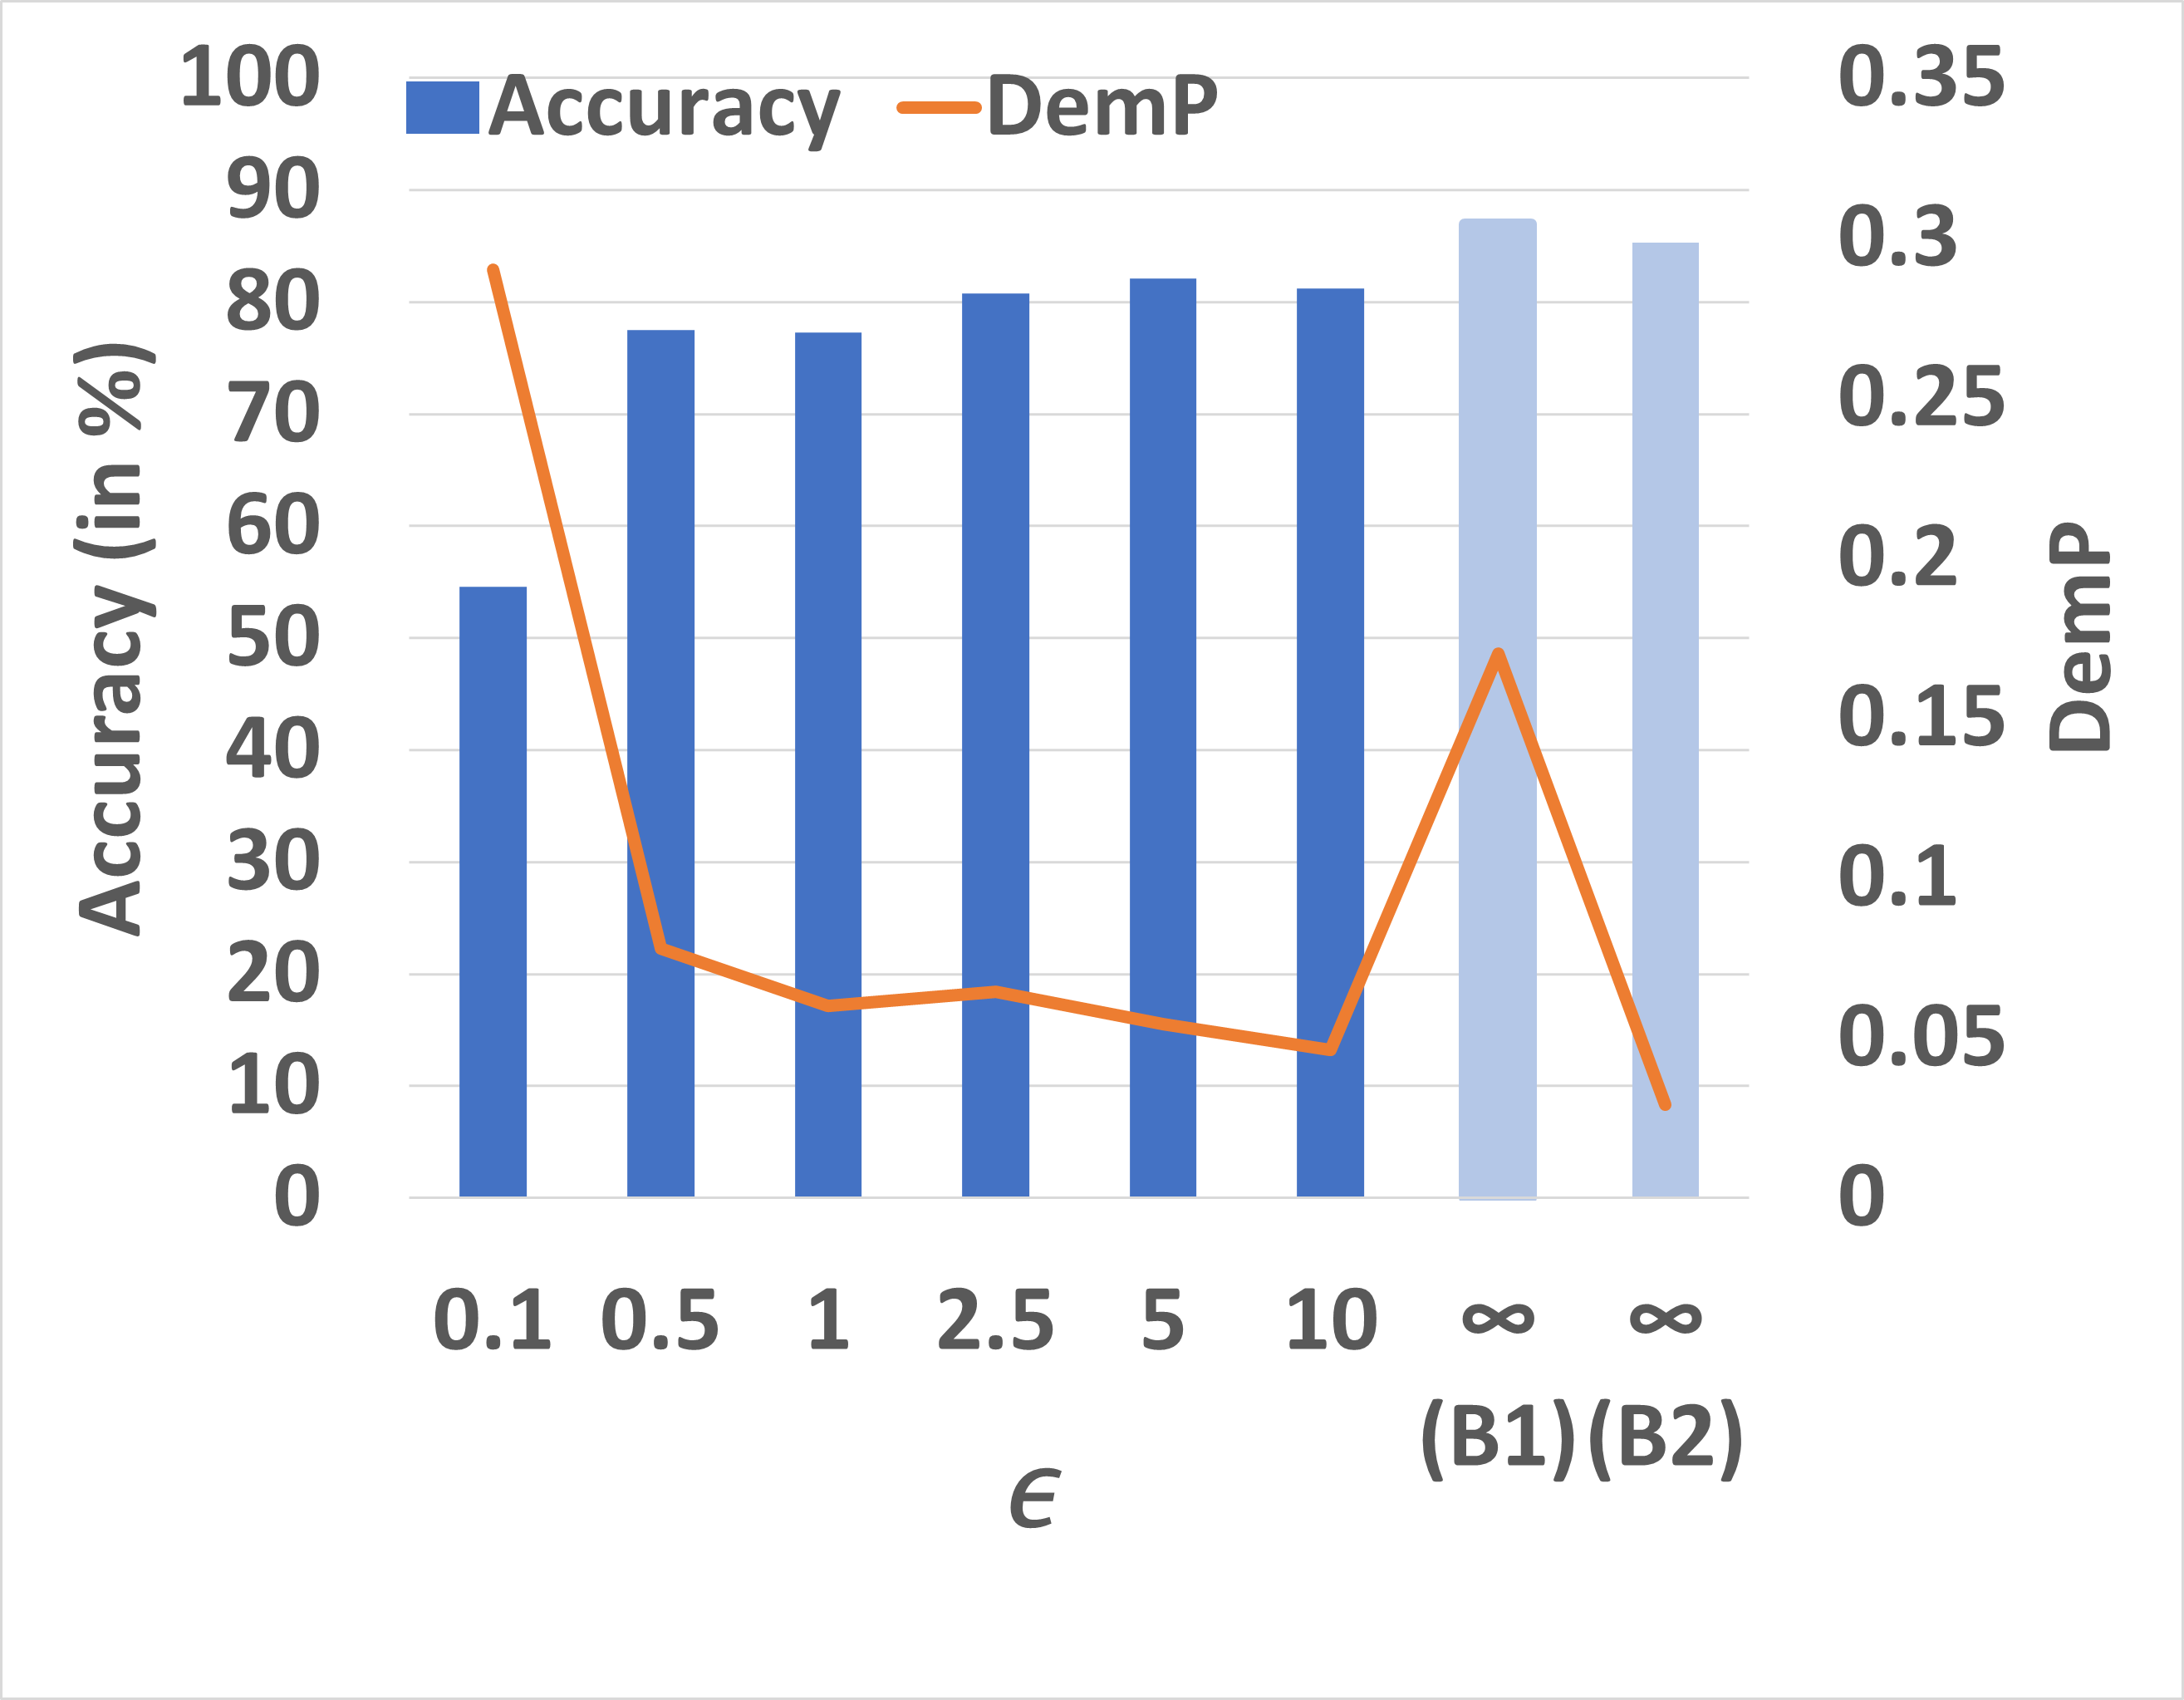

## Runtime

To run the code, change the runtime type: **Runtime -> Change Runtime Type -> T4 GPU**

## Setup
We first install the tensorflow privacy library, add necessary imports and download the ADULT and BANK datasets. To check out the details of the datasets, please check our paper: https://arxiv.org/pdf/2108.09932.pdf (Section 6)

In [1]:
!pip install tensorflow-privacy

  Using cached tensorflow_privacy-0.8.12-py3-none-any.whl (405 kB)
  Using cached dp_accounting-0.4.3-py3-none-any.whl (104 kB)
  Using cached immutabledict-2.2.5-py3-none-any.whl (4.1 kB)
  Using cached packaging-22.0-py3-none-any.whl (42 kB)
  Using cached tf_models_official-2.15.0-py2.py3-none-any.whl (2.7 MB)
  Using cached sacrebleu-2.4.0-py3-none-any.whl (106 kB)
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached tensorflow_model_optimization-0.7.5-py2.py3-none-any.whl (241 kB)
  Using cached tensorflow_text-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)
  Using cached portalocker-2.8.2-py3-none-any.whl (17 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 23.2
    Uninstalling packaging-23.2:
      Successfully uninstalled packaging-23.2
ERROR: pip's 

In [2]:
"""
IMPORTS
"""
import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd

tf.get_logger().setLevel('ERROR')
import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib
import tensorflow.keras.backend as kb
import h5py
from tqdm import tqdm

In [3]:
"""
Get the data
"""
!git clone "https://github.com/magnetar-iiith/FairPrivateDL.git"
!tar -xzf /content/FairPrivateDL/data.tar.gz

Cloning into 'FairPrivateDL'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 2.58 MiB | 5.17 MiB/s, done.
Resolving deltas: 100% (1/1), done.


We provide results for the ADULT dataset. Please uncomment the code for BANK to test the implementation for it.

In [4]:
"""
ADULT : the variable "data" stores the tuple (features, label) and the variable \
"prot" stores the sensitive attribute (i.e., gender for the ADULT dataset)
"""
df = pd.read_csv('data/adult_prot.csv')
df_ap = df.loc[(df['103']== 1) & (df['104'] == 1)]
df=df.append([df_ap]*1)
df = df[:-611]
data = df.values[:,:-1]
prot = df.values[:,-1]
print(data.shape, prot.shape)
feat_size = data.shape[1]-1


(50000, 104) (50000,)


<ipython-input-4-98576dce4cc7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append([df_ap]*1)


In [5]:
"""
BANK : the variable "data" stores the tuple (features, label) and the variable \
"prot" stores the sensitive attribute (i.e., age for the BANK dataset)
"""
# df = pd.read_csv('data/bank_prot.csv')
# indx = df[df['63'] == 0].index.values[:1188]
# update_df = df.drop(indx)

# data = update_df.values[:,:-1]
# prot = update_df.values[:,-1]
# print(sum(prot), data.shape)
# feat_size = data.shape[1] - 1
# print(sum(1 - data[:,-1]))

'\nBANK : the variable "data" stores the tuple (features, label) and the variable "prot" stores the sensitive attribute (i.e., age for the BANK dataset)\n'

## Hyperparameters
Includes the number of FL clients, LR, number of epochs, training data size, and the fairness and privacy parameters. You may change these to optimize on the accuracy-fairness-privacy tradeoff.

In [6]:
# fed_ml params
splits = 5
samples_per_network = int(0.8*len(data)/(splits))
models = []
data_split = []
rounds = 4 # global FL iterations

# architecture
hidden_size = [1000, 500] ## adult
# hidden_size = [500, 100]  ## bank

num_classes = 2
input_size = [samples_per_network, data.shape[1]-1]

"""
Fair-SGD Parameters
"""
rho = 10    # balances fairness and accuracy losses
batch_size = 500
num_epochs_phase1 = 70 # Phase 1
epsilon = 0.01 # not to be confused with the privacy parameter
learning_rate_phase1 = 5e-4
""""""

"""
DP-SGD Parameters
"""
l2_norm_clip = 1.5
noise_multiplier = 1.3  ### sigma
num_microbatches = 250
learning_rate_phase2 = 0.25 ## for phase 2
num_epochs_phase2 = 5
""""""

"""
Flags to create non-fair and/or non-private baselines
(fair_sgd,dp_sgd) : (False,False) B1 Baseline
(fair_sgd,dp_sgd) : (True,False) B2 Baseline
"""
fair_sgd = True
dp_sgd = True
""""""

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')


## DNN Model

In [7]:
def model_init(flag):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_size[0],
                               activation='relu',
                               input_shape=(feat_size,)),
        tf.keras.layers.Dense(hidden_size[1], activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])

    if flag is None:
        ## init weights from the fair model
        f = h5py.File('./demp_adult.h5', 'r')
        bias = []
        kernel = []
        for i in list(f.keys()):
            bias.append(f[i][i]['bias:0'].value)
            kernel.append(f[i][i]['kernel:0'].value)
        ctr = 0
        for layer in model.layers:
            if ctr == 2:
                layer.set_weights([kernel[ctr][:,:2], bias[ctr][:2]])
            else:
                layer.set_weights([kernel[ctr], bias[ctr]])
            ctr += 1
    return model

## Training function for fair-SGD


In [8]:
def fair_model(train_x, train_y, test_x, test_y, lr = None, num_epochs = None, train=True, wts=None, fair_flag = True):

    model = model_init(1)

    if wts != None:
        model.set_weights(wts)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def fair_loss(y_actual, rounded):

        y_true = y_actual[:,:2]
        output = rounded[:,:2]
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

        loss1 = loss(y_true, output)
        if fair_flag == True:
          prot_data = y_actual[:,2:]
          rounded = output
          c0 = kb.sum((rounded[:,1] * (prot_data[:,0])))/ (kb.sum(prot_data[:,0]))
          c1 = kb.sum((rounded[:,1]* prot_data[:,1]))/(kb.sum(prot_data[:,1]))
          loss2 = kb.maximum(kb.abs(c0 - c1) - epsilon, 0.0)
          return loss1 + rho * loss2
        else:
          return loss1

    def DemP(y_true, y_pred):
        y_pred = tf.nn.softmax(y_pred[:,:2])
        prot_data = y_true[:,2:]
        c0 = kb.sum((y_pred[:,1] * (prot_data[:,0])))/ (kb.sum(prot_data[:,0]))
        c1 = kb.sum((y_pred[:,1]* prot_data[:,1]))/(kb.sum(prot_data[:,1]))
        loss2 = kb.abs(c0 - c1)
        return loss2


    if train:
        model.compile(optimizer=optimizer, loss= fair_loss, metrics=['accuracy', DemP])
        es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', min_delta=0.01, patience=200)
        model.fit(train_x, train_y,
                  epochs=num_epochs,
                  validation_data=(test_x, test_y),
                  batch_size=batch_size, callbacks=[es,print_stats_callback],
                  verbose = 0) # stop notebook output

    else:
        model.set_weights(wts)
        model.compile(optimizer=optimizer, loss=fair_loss, metrics=['accuracy', DemP])
    return model

## Training function for DP-SGD

In [9]:
from tensorflow_privacy.privacy.optimizers import dp_optimizer


def train_per_model(train_x, train_y, test_x, test_y, model_target, lr = None, num_epochs = None, train=True, wts=None):

    # model_target = model_init(None) # use None to load a already trained fair model
    model = model_init(0)

    # DPAdamOptimizer
    # DPKerasSGDOptimizer
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=num_microbatches,
        learning_rate=lr)

    if wts != None:
        model.set_weights(wts)


    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, reduction=tf.losses.Reduction.NONE)

    if train:
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', min_delta=0.1, patience=10)
        """ generating fair-sgd model predictions """
        ### training
        model_pred = kb.eval(kb.softmax(model_target(train_x)))
        target_y = tf.cast(model_pred == tf.reduce_max(model_pred, 1, keepdims=True), tf.int32)
        ### testing
        model_test_pred = kb.eval(kb.softmax(model_target(test_x)))
        target_test_y = tf.cast(model_test_pred == tf.reduce_max(model_test_pred, 1, keepdims=True), tf.int32)
        # Element-wise row-wise comparison and sum along the axis
        # row_wise_comparison_sum = tf.reduce_sum(tf.cast((tf.reduce_all(tf.equal(target_y, train_y), axis=1)),  dtype=tf.int32))

        # print(f"comparing predictions with ground truth: {row_wise_comparison_sum.numpy()}")

        model.fit(train_x, target_y,
                  epochs=num_epochs,
                  validation_data=(test_x, test_y),
                  batch_size=batch_size, callbacks=[es],
                  verbose = 1)  # keep notebook output
    else:
        model.set_weights(wts)
    return model

## Train and test split

In [10]:
test_ix = np.random.randint(0, len(data), int(0.2*len(data)))
test_data = data[test_ix, :-1]
test_prot =  tf.keras.utils.to_categorical(prot[test_ix, np.newaxis], num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(data[test_ix, -1], num_classes=num_classes)
test_labels = np.append(test_labels, test_prot, 1)

split_datasets = []
split_labels = []
for i in range(splits):
    t_ix = np.random.randint(0, len(data), samples_per_network)
    split_datasets.append(data[t_ix, :-1])
    split_prot = tf.keras.utils.to_categorical(prot[t_ix, np.newaxis], num_classes=num_classes)
    split_labels.append(np.append(tf.keras.utils.to_categorical(data[t_ix, -1], num_classes=num_classes), split_prot, 1))



## Training

In [11]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import LambdaCallback

def DemP(y_true, y_pred):
  y_pred = y_pred[:,:2]
  prot_data = y_true[:,2:]
  c0 = kb.sum((y_pred[:,1] * (prot_data[:,0])))/ (kb.sum(prot_data[:,0]))
  c1 = kb.sum((y_pred[:,1]* prot_data[:,1]))/(kb.sum(prot_data[:,1]))
  loss2 = kb.abs(c0 - c1)
  return loss2

# Function to print statistics
def print_stats(epoch, logs):
  if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch + 1}, Training Loss: {logs['loss']}, Training Accuracy: {logs['accuracy']}, Validation Loss: {logs['val_loss']}, Validation Accuracy: {logs['val_accuracy']}")


def test_aggregated_model(agg_wts, round):
  model = model_init(1) # create a new model instance to store the aggregated weights
  model.set_weights(agg_wts)
  out_p = kb.eval(kb.softmax(model(test_data)))
  acc = accuracy_score(np.argmax(test_labels[:,:2],1), np.argmax(out_p, 1))
  demp = kb.eval(DemP(test_labels, out_p))
  print("\n ===================== Global Model Performance ================")
  print(f"Global Round: {round}. Accuracy: {acc}, DemP Loss: {demp}")
  print("==========================\n")

print_stats_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print_stats(epoch, logs))

In [12]:
trained_wts = None
for itr in tqdm(range(rounds)):
    print(f"\n Global Epoch: {itr}")
    for i in tqdm(range(splits)):
        print(f"\n Client: {i}")
        if fair_sgd == True:
          print(f"\n Fair-SGD (Phase 1)")
          model_1 = fair_model(split_datasets[i], split_labels[i], test_data, test_labels, learning_rate_phase1, num_epochs_phase1, wts = trained_wts, fair_flag = True)
        else:
          print("Only training for Accuracy... ")
          model_1 = fair_model(split_datasets[i], split_labels[i], test_data, test_labels, learning_rate_phase1, num_epochs_phase1, wts = trained_wts, fair_flag = False)

        # model_pred = kb.eval(kb.softmax(model_1(split_datasets[i])))
        # target_y = tf.cast(model_pred == tf.reduce_max(model_pred, 1, keepdims=True), tf.int32)
        # row_wise_comparison_sum = tf.reduce_sum(tf.cast((tf.reduce_all(tf.equal(target_y, split_labels[i][:,:2]), axis=1)),  dtype=tf.int32))
        # print('Before entering: ',row_wise_comparison_sum)

        if dp_sgd == True:
          print(f"\n DP-SGD (Phase 2)")
          model = train_per_model(split_datasets[i], split_labels[i][:,:2], test_data, test_labels[:,:2], model_1, learning_rate_phase2, num_epochs_phase2, wts = trained_wts)
        else:
          print("Skipping DP-SGD...")
          model = model_1
        if i == 0:
            layerwise_weights = []
            for l in model.get_weights():
                layerwise_weights.append(l/splits)
        else:
            ctr = 0
            for l in model.get_weights():
                layerwise_weights[ctr] += l/splits
                ctr += 1
    trained_wts = layerwise_weights
    test_aggregated_model(trained_wts, itr)

  0%|          | 0/4 [00:00<?, ?it/s]


 Global Epoch: 0



  0%|          | 0/5 [00:00<?, ?it/s]


 Client: 0

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.3956403434276581, Training Accuracy: 0.827750027179718, Validation Loss: 0.406806617975235, Validation Accuracy: 0.8144999742507935
Epoch 20, Training Loss: 0.33601611852645874, Training Accuracy: 0.847000002861023, Validation Loss: 0.3632963001728058, Validation Accuracy: 0.8281000256538391
Epoch 30, Training Loss: 0.2994699478149414, Training Accuracy: 0.8661249876022339, Validation Loss: 0.3546433448791504, Validation Accuracy: 0.8348000049591064
Epoch 40, Training Loss: 0.2606193423271179, Training Accuracy: 0.8822500109672546, Validation Loss: 0.3520243763923645, Validation Accuracy: 0.8361999988555908
Epoch 50, Training Loss: 0.24369706213474274, Training Accuracy: 0.8941249847412109, Validation Loss: 0.3665832281112671, Validation Accuracy: 0.8417999744415283
Epoch 60, Training Loss: 0.21659596264362335, Training Accuracy: 0.9071249961853027, Validation Loss: 0.37343719601631165, Validation Accuracy: 0.8414999842643738



 20%|██        | 1/5 [00:45<03:02, 45.70s/it]


 Client: 1

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.3986475169658661, Training Accuracy: 0.8205000162124634, Validation Loss: 0.40462765097618103, Validation Accuracy: 0.814300000667572
Epoch 20, Training Loss: 0.34164029359817505, Training Accuracy: 0.8450000286102295, Validation Loss: 0.36207664012908936, Validation Accuracy: 0.8312000036239624
Epoch 30, Training Loss: 0.3078605532646179, Training Accuracy: 0.859125018119812, Validation Loss: 0.3573908805847168, Validation Accuracy: 0.8309999704360962
Epoch 40, Training Loss: 0.27396851778030396, Training Accuracy: 0.8783749938011169, Validation Loss: 0.35111233592033386, Validation Accuracy: 0.8381999731063843
Epoch 50, Training Loss: 0.2464609295129776, Training Accuracy: 0.8901249766349792, Validation Loss: 0.3599894046783447, Validation Accuracy: 0.8410999774932861
Epoch 60, Training Loss: 0.22529903054237366, Training Accuracy: 0.8971250057220459, Validation Loss: 0.3721707761287689, Validation Accuracy: 0.84079998731613


 40%|████      | 2/5 [01:17<01:52, 37.64s/it]


 Client: 2

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.41610708832740784, Training Accuracy: 0.8181250095367432, Validation Loss: 0.4884120225906372, Validation Accuracy: 0.8113999962806702
Epoch 20, Training Loss: 0.35246947407722473, Training Accuracy: 0.8358749747276306, Validation Loss: 0.36958959698677063, Validation Accuracy: 0.8245999813079834
Epoch 30, Training Loss: 0.32515400648117065, Training Accuracy: 0.8525000214576721, Validation Loss: 0.3561064898967743, Validation Accuracy: 0.833899974822998
Epoch 40, Training Loss: 0.29301315546035767, Training Accuracy: 0.8688750267028809, Validation Loss: 0.3491872549057007, Validation Accuracy: 0.8363999724388123
Epoch 50, Training Loss: 0.26393845677375793, Training Accuracy: 0.8827499747276306, Validation Loss: 0.35308775305747986, Validation Accuracy: 0.8361999988555908
Epoch 60, Training Loss: 0.24132391810417175, Training Accuracy: 0.8947499990463257, Validation Loss: 0.36293119192123413, Validation Accuracy: 0.8378999829


 60%|██████    | 3/5 [01:50<01:10, 35.49s/it]


 Client: 3

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.4092438817024231, Training Accuracy: 0.8172500133514404, Validation Loss: 0.40450817346572876, Validation Accuracy: 0.8131999969482422
Epoch 20, Training Loss: 0.3426477909088135, Training Accuracy: 0.8447499871253967, Validation Loss: 0.3678895831108093, Validation Accuracy: 0.8287000060081482
Epoch 30, Training Loss: 0.31349682807922363, Training Accuracy: 0.8607500195503235, Validation Loss: 0.35706669092178345, Validation Accuracy: 0.8310999870300293
Epoch 40, Training Loss: 0.2838008999824524, Training Accuracy: 0.8787500262260437, Validation Loss: 0.3499629497528076, Validation Accuracy: 0.8342000246047974
Epoch 50, Training Loss: 0.24788229167461395, Training Accuracy: 0.8911250233650208, Validation Loss: 0.3553605079650879, Validation Accuracy: 0.8345999717712402
Epoch 60, Training Loss: 0.2240399718284607, Training Accuracy: 0.9003750085830688, Validation Loss: 0.36743268370628357, Validation Accuracy: 0.8360999822616


 80%|████████  | 4/5 [02:26<00:35, 35.54s/it]


 Client: 4

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.40015387535095215, Training Accuracy: 0.825124979019165, Validation Loss: 0.4140298366546631, Validation Accuracy: 0.8126000165939331
Epoch 20, Training Loss: 0.34146472811698914, Training Accuracy: 0.8464999794960022, Validation Loss: 0.3695143163204193, Validation Accuracy: 0.8260999917984009
Epoch 30, Training Loss: 0.3061322569847107, Training Accuracy: 0.8638749718666077, Validation Loss: 0.357791930437088, Validation Accuracy: 0.8325999975204468
Epoch 40, Training Loss: 0.269819974899292, Training Accuracy: 0.8823750019073486, Validation Loss: 0.3566606342792511, Validation Accuracy: 0.8342000246047974
Epoch 50, Training Loss: 0.24226221442222595, Training Accuracy: 0.8951249718666077, Validation Loss: 0.36326485872268677, Validation Accuracy: 0.8370000123977661
Epoch 60, Training Loss: 0.21751374006271362, Training Accuracy: 0.9057499766349792, Validation Loss: 0.37691447138786316, Validation Accuracy: 0.836799979209899


 25%|██▌       | 1/4 [02:51<08:34, 171.40s/it]


 ===================== Global Model Performance ================
Global Round: 0. Accuracy: 0.7364, DemP Loss: 0.00712132453918457


 Global Epoch: 1



  0%|          | 0/5 [00:00<?, ?it/s]


 Client: 0

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.3528043031692505, Training Accuracy: 0.8395000100135803, Validation Loss: 0.3694753050804138, Validation Accuracy: 0.8269000053405762
Epoch 20, Training Loss: 0.2917909622192383, Training Accuracy: 0.8676249980926514, Validation Loss: 0.34808680415153503, Validation Accuracy: 0.8382999897003174
Epoch 30, Training Loss: 0.25201815366744995, Training Accuracy: 0.8868749737739563, Validation Loss: 0.36034390330314636, Validation Accuracy: 0.8395000100135803
Epoch 40, Training Loss: 0.23008152842521667, Training Accuracy: 0.9022499918937683, Validation Loss: 0.374610036611557, Validation Accuracy: 0.8342000246047974
Epoch 50, Training Loss: 0.20270763337612152, Training Accuracy: 0.9104999899864197, Validation Loss: 0.3905434012413025, Validation Accuracy: 0.8391000032424927
Epoch 60, Training Loss: 0.19631415605545044, Training Accuracy: 0.9171249866485596, Validation Loss: 0.4124457538127899, Validation Accuracy: 0.8392999768257


 20%|██        | 1/5 [00:25<01:42, 25.61s/it]


 Client: 1

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.35237035155296326, Training Accuracy: 0.8386250138282776, Validation Loss: 0.37397056818008423, Validation Accuracy: 0.8264999985694885
Epoch 20, Training Loss: 0.30063024163246155, Training Accuracy: 0.8653749823570251, Validation Loss: 0.35418257117271423, Validation Accuracy: 0.8345000147819519
Epoch 30, Training Loss: 0.26340168714523315, Training Accuracy: 0.8821250200271606, Validation Loss: 0.3704814910888672, Validation Accuracy: 0.8334000110626221
Epoch 40, Training Loss: 0.2352106273174286, Training Accuracy: 0.893875002861023, Validation Loss: 0.3669047951698303, Validation Accuracy: 0.8432999849319458
Epoch 50, Training Loss: 0.21103227138519287, Training Accuracy: 0.9067500233650208, Validation Loss: 0.3891076147556305, Validation Accuracy: 0.8438000082969666
Epoch 60, Training Loss: 0.19763322174549103, Training Accuracy: 0.9100000262260437, Validation Loss: 0.40945643186569214, Validation Accuracy: 0.84130001068


 40%|████      | 2/5 [00:58<01:28, 29.60s/it]


 Client: 2

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.3585297465324402, Training Accuracy: 0.8305000066757202, Validation Loss: 0.3687064051628113, Validation Accuracy: 0.8248000144958496
Epoch 20, Training Loss: 0.31005510687828064, Training Accuracy: 0.859000027179718, Validation Loss: 0.3471968472003937, Validation Accuracy: 0.8393999934196472
Epoch 30, Training Loss: 0.26766273379325867, Training Accuracy: 0.8811249732971191, Validation Loss: 0.35087063908576965, Validation Accuracy: 0.84170001745224
Epoch 40, Training Loss: 0.23744332790374756, Training Accuracy: 0.8951249718666077, Validation Loss: 0.3668409585952759, Validation Accuracy: 0.8403000235557556
Epoch 50, Training Loss: 0.2172536551952362, Training Accuracy: 0.9037500023841858, Validation Loss: 0.39460086822509766, Validation Accuracy: 0.8414999842643738
Epoch 60, Training Loss: 0.20563803613185883, Training Accuracy: 0.9068750143051147, Validation Loss: 0.4134562909603119, Validation Accuracy: 0.837000012397766


 60%|██████    | 3/5 [01:30<01:01, 30.90s/it]


 Client: 3

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.3474080264568329, Training Accuracy: 0.8414999842643738, Validation Loss: 0.3661573529243469, Validation Accuracy: 0.8287000060081482
Epoch 20, Training Loss: 0.29867789149284363, Training Accuracy: 0.8650000095367432, Validation Loss: 0.3509144186973572, Validation Accuracy: 0.8357999920845032
Epoch 30, Training Loss: 0.2653506100177765, Training Accuracy: 0.8857499957084656, Validation Loss: 0.35267317295074463, Validation Accuracy: 0.8396999835968018
Epoch 40, Training Loss: 0.23312047123908997, Training Accuracy: 0.8972499966621399, Validation Loss: 0.3729712665081024, Validation Accuracy: 0.8361999988555908
Epoch 50, Training Loss: 0.2114734947681427, Training Accuracy: 0.906125009059906, Validation Loss: 0.3905978798866272, Validation Accuracy: 0.8324000239372253
Epoch 60, Training Loss: 0.19282861053943634, Training Accuracy: 0.9108750224113464, Validation Loss: 0.4097937047481537, Validation Accuracy: 0.832799971103668


 80%|████████  | 4/5 [02:04<00:32, 32.16s/it]


 Client: 4

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.3456255793571472, Training Accuracy: 0.8411250114440918, Validation Loss: 0.36967232823371887, Validation Accuracy: 0.8238999843597412
Epoch 20, Training Loss: 0.30439838767051697, Training Accuracy: 0.8691250085830688, Validation Loss: 0.35478654503822327, Validation Accuracy: 0.8363000154495239
Epoch 30, Training Loss: 0.25333884358406067, Training Accuracy: 0.8883749842643738, Validation Loss: 0.3604137599468231, Validation Accuracy: 0.8348000049591064
Epoch 40, Training Loss: 0.2296043485403061, Training Accuracy: 0.9011250138282776, Validation Loss: 0.38179105520248413, Validation Accuracy: 0.8303999900817871
Epoch 50, Training Loss: 0.2067055106163025, Training Accuracy: 0.9067500233650208, Validation Loss: 0.4007627069950104, Validation Accuracy: 0.8325999975204468
Epoch 60, Training Loss: 0.1982884407043457, Training Accuracy: 0.9096249938011169, Validation Loss: 0.4369881749153137, Validation Accuracy: 0.8338999748229


 50%|█████     | 2/4 [05:40<05:39, 169.90s/it]


 ===================== Global Model Performance ================
Global Round: 1. Accuracy: 0.8028, DemP Loss: 0.15217265486717224


 Global Epoch: 2



  0%|          | 0/5 [00:00<?, ?it/s]


 Client: 0

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.4072797894477844, Training Accuracy: 0.8197500109672546, Validation Loss: 0.40935826301574707, Validation Accuracy: 0.8123999834060669
Epoch 20, Training Loss: 0.3539556860923767, Training Accuracy: 0.8413749933242798, Validation Loss: 0.40224239230155945, Validation Accuracy: 0.8264999985694885
Epoch 30, Training Loss: 0.3189903497695923, Training Accuracy: 0.8601250052452087, Validation Loss: 0.3974640965461731, Validation Accuracy: 0.835099995136261
Epoch 40, Training Loss: 0.27680596709251404, Training Accuracy: 0.8776249885559082, Validation Loss: 0.352542906999588, Validation Accuracy: 0.8396000266075134
Epoch 50, Training Loss: 0.24860000610351562, Training Accuracy: 0.8882499933242798, Validation Loss: 0.3546834886074066, Validation Accuracy: 0.839900016784668
Epoch 60, Training Loss: 0.22927242517471313, Training Accuracy: 0.8970000147819519, Validation Loss: 0.37170904874801636, Validation Accuracy: 0.837599992752075


 20%|██        | 1/5 [00:32<02:10, 32.70s/it]


 Client: 1

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.42586657404899597, Training Accuracy: 0.8101249933242798, Validation Loss: 0.42373812198638916, Validation Accuracy: 0.8101000189781189
Epoch 20, Training Loss: 0.3812885582447052, Training Accuracy: 0.8383749723434448, Validation Loss: 0.37213534116744995, Validation Accuracy: 0.8266000151634216
Epoch 30, Training Loss: 0.3359227776527405, Training Accuracy: 0.8538749814033508, Validation Loss: 0.35393184423446655, Validation Accuracy: 0.8327999711036682
Epoch 40, Training Loss: 0.2889869511127472, Training Accuracy: 0.8706250190734863, Validation Loss: 0.3541063964366913, Validation Accuracy: 0.8343999981880188
Epoch 50, Training Loss: 0.27195948362350464, Training Accuracy: 0.8815000057220459, Validation Loss: 0.355090856552124, Validation Accuracy: 0.8403000235557556
Epoch 60, Training Loss: 0.24400193989276886, Training Accuracy: 0.890500009059906, Validation Loss: 0.3665391206741333, Validation Accuracy: 0.83719998598098


 40%|████      | 2/5 [01:05<01:38, 32.92s/it]


 Client: 2

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.4498707950115204, Training Accuracy: 0.8143749833106995, Validation Loss: 0.48666396737098694, Validation Accuracy: 0.8118000030517578
Epoch 20, Training Loss: 0.3704643249511719, Training Accuracy: 0.8323749899864197, Validation Loss: 0.37247368693351746, Validation Accuracy: 0.8252999782562256
Epoch 30, Training Loss: 0.3310246765613556, Training Accuracy: 0.8466249704360962, Validation Loss: 0.3547588586807251, Validation Accuracy: 0.8325999975204468
Epoch 40, Training Loss: 0.3061427175998688, Training Accuracy: 0.8627499938011169, Validation Loss: 0.37609046697616577, Validation Accuracy: 0.8378999829292297
Epoch 50, Training Loss: 0.26894667744636536, Training Accuracy: 0.8784999847412109, Validation Loss: 0.35131847858428955, Validation Accuracy: 0.8410999774932861
Epoch 60, Training Loss: 0.2652542293071747, Training Accuracy: 0.8881250023841858, Validation Loss: 0.36481621861457825, Validation Accuracy: 0.839699983596


 60%|██████    | 3/5 [01:30<00:58, 29.22s/it]


 Client: 3

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.4306260347366333, Training Accuracy: 0.8143749833106995, Validation Loss: 0.41844049096107483, Validation Accuracy: 0.8144000172615051
Epoch 20, Training Loss: 0.35197317600250244, Training Accuracy: 0.8420000076293945, Validation Loss: 0.36924102902412415, Validation Accuracy: 0.82669997215271
Epoch 30, Training Loss: 0.31752872467041016, Training Accuracy: 0.8604999780654907, Validation Loss: 0.3753337860107422, Validation Accuracy: 0.833299994468689
Epoch 40, Training Loss: 0.29276394844055176, Training Accuracy: 0.8692499995231628, Validation Loss: 0.36402419209480286, Validation Accuracy: 0.8314999938011169
Epoch 50, Training Loss: 0.26229995489120483, Training Accuracy: 0.8824999928474426, Validation Loss: 0.3523713946342468, Validation Accuracy: 0.8381999731063843
Epoch 60, Training Loss: 0.237673819065094, Training Accuracy: 0.8956249952316284, Validation Loss: 0.3652016520500183, Validation Accuracy: 0.836899995803833


 80%|████████  | 4/5 [02:03<00:30, 30.83s/it]


 Client: 4

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.4401422142982483, Training Accuracy: 0.8205000162124634, Validation Loss: 0.42643237113952637, Validation Accuracy: 0.8086000084877014
Epoch 20, Training Loss: 0.3680287003517151, Training Accuracy: 0.8383749723434448, Validation Loss: 0.37396731972694397, Validation Accuracy: 0.8227999806404114
Epoch 30, Training Loss: 0.31537261605262756, Training Accuracy: 0.8567500114440918, Validation Loss: 0.35911816358566284, Validation Accuracy: 0.8341000080108643
Epoch 40, Training Loss: 0.31278204917907715, Training Accuracy: 0.8727499842643738, Validation Loss: 0.3888755142688751, Validation Accuracy: 0.8389999866485596
Epoch 50, Training Loss: 0.26349273324012756, Training Accuracy: 0.8843749761581421, Validation Loss: 0.35920265316963196, Validation Accuracy: 0.8370000123977661
Epoch 60, Training Loss: 0.24360781908035278, Training Accuracy: 0.8983749747276306, Validation Loss: 0.3720815181732178, Validation Accuracy: 0.8363000154


 75%|███████▌  | 3/4 [08:09<02:40, 160.38s/it]


 ===================== Global Model Performance ================
Global Round: 2. Accuracy: 0.8101, DemP Loss: 0.1508420705795288


 Global Epoch: 3



  0%|          | 0/5 [00:00<?, ?it/s]


 Client: 0

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.5061371326446533, Training Accuracy: 0.812874972820282, Validation Loss: 0.45361390709877014, Validation Accuracy: 0.8061000108718872
Epoch 20, Training Loss: 0.39712610840797424, Training Accuracy: 0.8320000171661377, Validation Loss: 0.391342431306839, Validation Accuracy: 0.8209999799728394
Epoch 30, Training Loss: 0.35133883357048035, Training Accuracy: 0.8454999923706055, Validation Loss: 0.36218637228012085, Validation Accuracy: 0.8288000226020813
Epoch 40, Training Loss: 0.30798467993736267, Training Accuracy: 0.8622499704360962, Validation Loss: 0.35087546706199646, Validation Accuracy: 0.8341000080108643
Epoch 50, Training Loss: 0.2741655707359314, Training Accuracy: 0.875374972820282, Validation Loss: 0.3473098576068878, Validation Accuracy: 0.8373000025749207
Epoch 60, Training Loss: 0.26069170236587524, Training Accuracy: 0.8868749737739563, Validation Loss: 0.3568892776966095, Validation Accuracy: 0.83980000019073


 20%|██        | 1/5 [00:25<01:42, 25.59s/it]


 Client: 1

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.45637109875679016, Training Accuracy: 0.8137500286102295, Validation Loss: 0.4511546790599823, Validation Accuracy: 0.810699999332428
Epoch 20, Training Loss: 0.4061470329761505, Training Accuracy: 0.8295000195503235, Validation Loss: 0.386051207780838, Validation Accuracy: 0.8224999904632568
Epoch 30, Training Loss: 0.34512975811958313, Training Accuracy: 0.8457499742507935, Validation Loss: 0.3622121512889862, Validation Accuracy: 0.8312000036239624
Epoch 40, Training Loss: 0.3695092797279358, Training Accuracy: 0.8581249713897705, Validation Loss: 0.4546884298324585, Validation Accuracy: 0.8294000029563904
Epoch 50, Training Loss: 0.28853148221969604, Training Accuracy: 0.8731250166893005, Validation Loss: 0.34847867488861084, Validation Accuracy: 0.838100016117096
Epoch 60, Training Loss: 0.2701402008533478, Training Accuracy: 0.8857499957084656, Validation Loss: 0.4115629494190216, Validation Accuracy: 0.8389000296592712



 40%|████      | 2/5 [00:58<01:30, 30.16s/it]


 Client: 2

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.4720628559589386, Training Accuracy: 0.8111249804496765, Validation Loss: 0.42724087834358215, Validation Accuracy: 0.8115000128746033
Epoch 20, Training Loss: 0.377271443605423, Training Accuracy: 0.8263750076293945, Validation Loss: 0.3838654160499573, Validation Accuracy: 0.8217999935150146
Epoch 30, Training Loss: 0.3581782579421997, Training Accuracy: 0.8402500152587891, Validation Loss: 0.3773725628852844, Validation Accuracy: 0.8285999894142151
Epoch 40, Training Loss: 0.33555856347084045, Training Accuracy: 0.8551250100135803, Validation Loss: 0.3563891649246216, Validation Accuracy: 0.8367000222206116
Epoch 50, Training Loss: 0.30008479952812195, Training Accuracy: 0.8678749799728394, Validation Loss: 0.3451796770095825, Validation Accuracy: 0.8375999927520752
Epoch 60, Training Loss: 0.27740582823753357, Training Accuracy: 0.8811249732971191, Validation Loss: 0.3553631901741028, Validation Accuracy: 0.841400027275085


 60%|██████    | 3/5 [01:32<01:03, 31.87s/it]


 Client: 3

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.41511622071266174, Training Accuracy: 0.812125027179718, Validation Loss: 0.43126240372657776, Validation Accuracy: 0.8095999956130981
Epoch 20, Training Loss: 0.3881847560405731, Training Accuracy: 0.8336250185966492, Validation Loss: 0.3800047039985657, Validation Accuracy: 0.8213000297546387
Epoch 30, Training Loss: 0.3434542417526245, Training Accuracy: 0.8489999771118164, Validation Loss: 0.36371034383773804, Validation Accuracy: 0.8289999961853027
Epoch 40, Training Loss: 0.3114372789859772, Training Accuracy: 0.8602499961853027, Validation Loss: 0.36449456214904785, Validation Accuracy: 0.8335999846458435
Epoch 50, Training Loss: 0.2870941460132599, Training Accuracy: 0.8727499842643738, Validation Loss: 0.34965837001800537, Validation Accuracy: 0.8374000191688538
Epoch 60, Training Loss: 0.2623668909072876, Training Accuracy: 0.8837500214576721, Validation Loss: 0.3534311354160309, Validation Accuracy: 0.83509999513626


 80%|████████  | 4/5 [01:58<00:29, 29.24s/it]


 Client: 4

 Fair-SGD (Phase 1)
Epoch 10, Training Loss: 0.4182877540588379, Training Accuracy: 0.8208749890327454, Validation Loss: 0.4295385181903839, Validation Accuracy: 0.8093000054359436
Epoch 20, Training Loss: 0.3724973201751709, Training Accuracy: 0.8335000276565552, Validation Loss: 0.38390201330184937, Validation Accuracy: 0.8205000162124634
Epoch 30, Training Loss: 0.358081579208374, Training Accuracy: 0.8479999899864197, Validation Loss: 0.3624732494354248, Validation Accuracy: 0.8303999900817871
Epoch 40, Training Loss: 0.3329485356807709, Training Accuracy: 0.8621249794960022, Validation Loss: 0.35580411553382874, Validation Accuracy: 0.8361999988555908
Epoch 50, Training Loss: 0.28259068727493286, Training Accuracy: 0.8768749833106995, Validation Loss: 0.35772931575775146, Validation Accuracy: 0.8360000252723694
Epoch 60, Training Loss: 0.25906631350517273, Training Accuracy: 0.8867499828338623, Validation Loss: 0.3585408627986908, Validation Accuracy: 0.83829998970031


100%|██████████| 4/4 [10:33<00:00, 158.26s/it]


 ===================== Global Model Performance ================
Global Round: 3. Accuracy: 0.8137, DemP Loss: 0.1289009153842926



### Testing

In [13]:
from sklearn.metrics import accuracy_score

model = model_init(1) # create a new model instance to store the aggregated weights
model.set_weights(trained_wts)
out_p = kb.eval(model(test_data))
acc = accuracy_score(np.argmax(test_labels[:,:2],1), np.argmax(out_p, 1))
demp = kb.eval(DemP(test_labels, out_p))
print(f"Accuracy: {acc}, DemP Loss: {demp}")

### For dp estimate
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(number_of_examples=input_size[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              num_epochs=num_epochs_phase2 * rounds,
                                              delta=1e-4)

Accuracy: 0.8137, DemP Loss: 0.9985425472259521


'DP-SGD performed over 8000 examples with 500 examples per iteration, noise\nmultiplier 1.3 for 20 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.0001 computed\nwith RDP accounting:\n    Epsilon with each example occurring once per epoch:        51.456\n    Epsilon assuming Poisson sampling (*):                     19.303\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed the actual epsilon should be\ncloser to this value than the conservative assumption of an arbitrary data\norder.\n'